In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('/home/kinjal/Documents/Project 2/Airbnb_data.csv', low_memory = False)
df

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102594,6092437,Spare room in Williamsburg,12312296767,verified,Krik,Brooklyn,Williamsburg,40.70862,-73.94651,United States,...,$169,1.0,0.0,NaN,NaN,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,NaN
102595,6092990,Best Location near Columbia U,77864383453,unconfirmed,Mifan,Manhattan,Morningside Heights,40.80460,-73.96545,United States,...,$167,1.0,1.0,7/6/2015,0.02,2.0,2.0,395.0,House rules: Guests agree to the following ter...,NaN
102596,6093542,"Comfy, bright room in Brooklyn",69050334417,unconfirmed,Megan,Brooklyn,Park Slope,40.67505,-73.98045,United States,...,$198,3.0,0.0,NaN,NaN,5.0,1.0,342.0,NaN,NaN
102597,6094094,Big Studio-One Stop from Midtown,11160591270,unconfirmed,Christopher,Queens,Long Island City,40.74989,-73.93777,United States,...,$109,2.0,5.0,10/11/2015,0.10,3.0,1.0,386.0,NaN,NaN


In [3]:
# Check column names in the dataset

df.columns

Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object')

## Check for missing values

In [4]:
# Check for missing values

print(df.isnull().sum())

id                                     0
NAME                                 250
host id                                0
host_identity_verified               289
host name                            406
neighbourhood group                   29
neighbourhood                         16
lat                                    8
long                                   8
country                              532
country code                         131
instant_bookable                     105
cancellation_policy                   76
room type                              0
Construction year                    214
price                                247
service fee                          273
minimum nights                       409
number of reviews                    183
last review                        15893
reviews per month                  15879
review rate number                   326
calculated host listings count       319
availability 365                     448
house_rules     

## Handle Missing Values

In [5]:
# Convert 'last review' to datetime and handle errors

df['last review'] = pd.to_datetime(df['last review'], errors = 'coerce')

In [6]:
# Fill missing values

df.fillna({'reviews per month': 0, 'last review': df['last review'].min()}, inplace = True)

In [7]:
# Drop records with missing 'name' or 'host name'

df.dropna(subset = ['NAME','host name'], inplace = True)

df = df.drop(columns = ['house_rules','license'], errors = 'ignore')

In [8]:
# Drop columns not useful for prediction

drop_cols = ['id', 'NAME', 'host id', 'host name', 'country', 'country code', 'last review']
df = df.drop(columns=drop_cols)

In [9]:
# Drop rows with missing target or predictor values

df = df.dropna(subset=['price'])

In [10]:
df.columns

Index(['host_identity_verified', 'neighbourhood group', 'neighbourhood', 'lat',
       'long', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'reviews per month', 'review rate number',
       'calculated host listings count', 'availability 365'],
      dtype='object')

In [11]:
print(df.isnull().sum())

host_identity_verified            272
neighbourhood group                25
neighbourhood                      15
lat                                 8
long                                8
instant_bookable                   91
cancellation_policy                65
room type                           0
Construction year                 196
price                               0
service fee                       239
minimum nights                    403
number of reviews                 182
reviews per month                   0
review rate number                314
calculated host listings count    318
availability 365                  420
dtype: int64


## Correct data types

In [12]:
# Remove dollar signs and convert to float

df['price'] = df['price'].replace('[$,]', '', regex = True).astype(float)
df['service fee'] = df['service fee'].replace('[$,]', '', regex = True).astype(float)

In [13]:
df.head()

,host_identity_verified,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,0.38,4.0,2.0,228.0
2,NaN,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,0.00,5.0,1.0,352.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0
5,verified,Manhattan,Murray Hill,40.74767,-73.97500,True,flexible,Entire home/apt,2013.0,577.0,115.0,3.0,74.0,0.59,3.0,1.0,374.0


## Remove Duplicates

In [14]:
df.drop_duplicates(inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98109 entries, 0 to 102057
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_identity_verified          97837 non-null  object 
 1   neighbourhood group             98084 non-null  object 
 2   neighbourhood                   98094 non-null  object 
 3   lat                             98101 non-null  float64
 4   long                            98101 non-null  float64
 5   instant_bookable                98018 non-null  object 
 6   cancellation_policy             98044 non-null  object 
 7   room type                       98109 non-null  object 
 8   Construction year               97913 non-null  float64
 9   price                           98109 non-null  float64
 10  service fee                     97870 non-null  float64
 11  minimum nights                  97717 non-null  float64
 12  number of reviews               9793

## Descriptive Statistics

In [16]:
round(df.describe(), 2)

,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,98101.00,98101.00,97913.00,98109.00,97870.00,97717.00,97930.00,98109.00,97808.00,97802.00,97689.00
mean,40.73,-73.95,2012.49,625.29,125.04,8.14,27.58,1.16,3.28,7.99,142.14
std,0.06,0.05,5.77,331.69,66.34,30.71,49.84,1.69,1.28,32.41,135.45
min,40.50,-74.25,2003.00,50.00,10.00,-1223.00,0.00,0.00,1.00,1.00,-10.00
25%,40.69,-73.98,2007.00,339.00,68.00,2.00,1.00,0.09,2.00,1.00,4.00
50%,40.72,-73.95,2012.00,625.00,125.00,3.00,7.00,0.48,3.00,1.00,99.00
75%,40.76,-73.93,2017.00,913.00,183.00,5.00,30.00,1.71,4.00,2.00,270.00
max,40.92,-73.71,2022.00,1200.00,240.00,5645.00,1024.00,90.00,5.00,332.00,3677.00


## Distribution of Prices

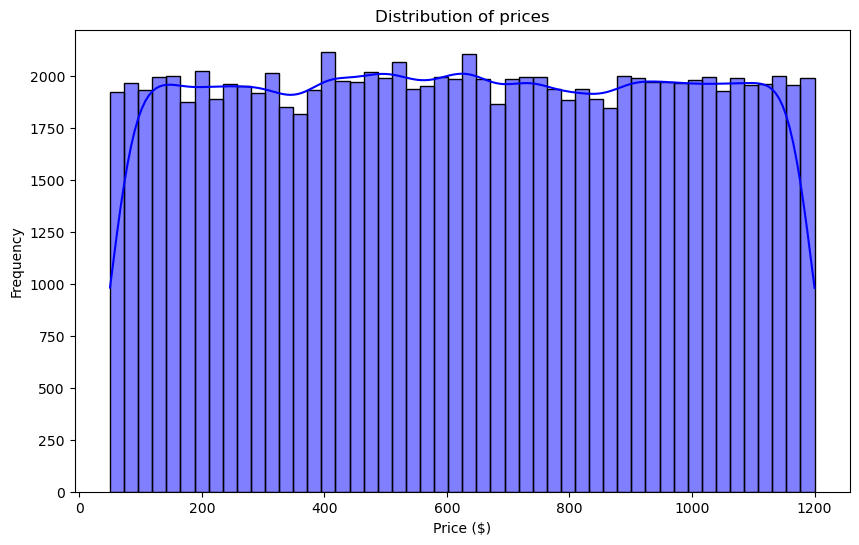

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,6))
sns.histplot(df['price'], bins = 50, kde = True, color = 'blue')
plt.title('Distribution of prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

### This histogram shows a fairly even distribution of listing prices across different price ranges, indicating no particular concentration of listings in any specific proce range.

### The KDE line helps us visualize the even spread more clearly, confirming that the dataset contains listings with a wide variety of prices. 

## Room Type Analysis

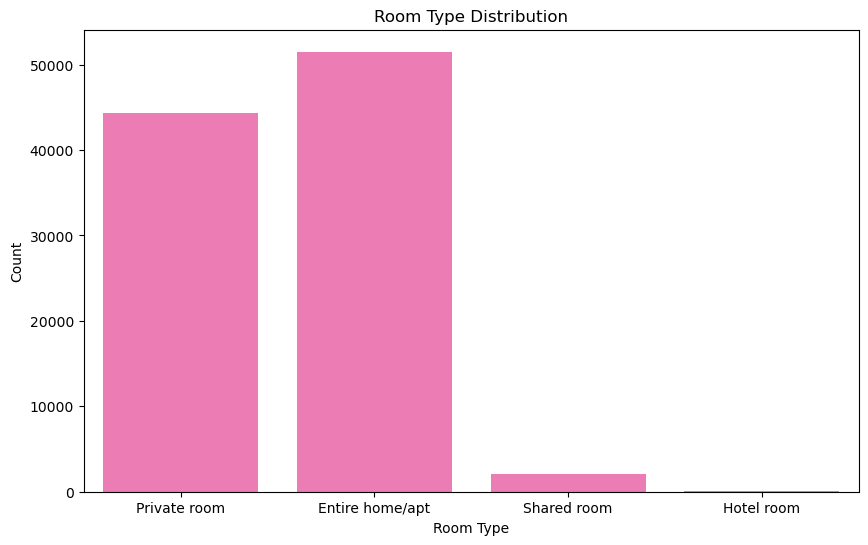

In [18]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'room type', data = df, color = 'hotpink')
plt.title('Room Type Distribution')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

### The countplot shows a clear distribution of different types of room available in the Airbnb dataset.

### The majority of listings are for 'Private room' and 'Entire home/apt', with 'Shared room' and 'Hotel room' are being much less in common.

### This insight can be useful for understanding the availability and popularity of different types of accomodations on Airbnb.

## Neighbourhood Analysis

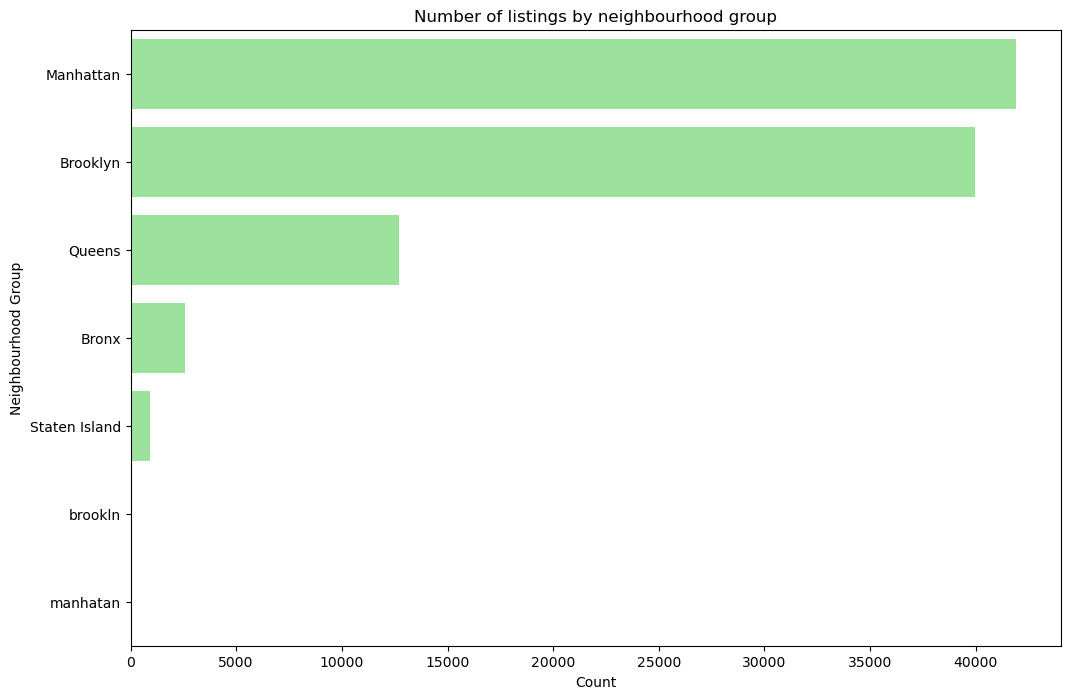

In [19]:
plt.figure(figsize = (12,8))
sns.countplot(y = 'neighbourhood group', data = df, color = 'lightgreen', order = df['neighbourhood group'].value_counts().index)
plt.title('Number of listings by neighbourhood group')
plt.xlabel('Count')
plt.ylabel('Neighbourhood Group')
plt.show()

### The countplot shows a clear distribution of the number of listings across different neighbourhood groups. 

### Manhattan and Brooklyn dominate the listings, which suggests that they are the prime locations for AIrbnb.

### Bronx and Staten island have fewer listings, indicating less availability or popularity.

## Price Vs. Room Type

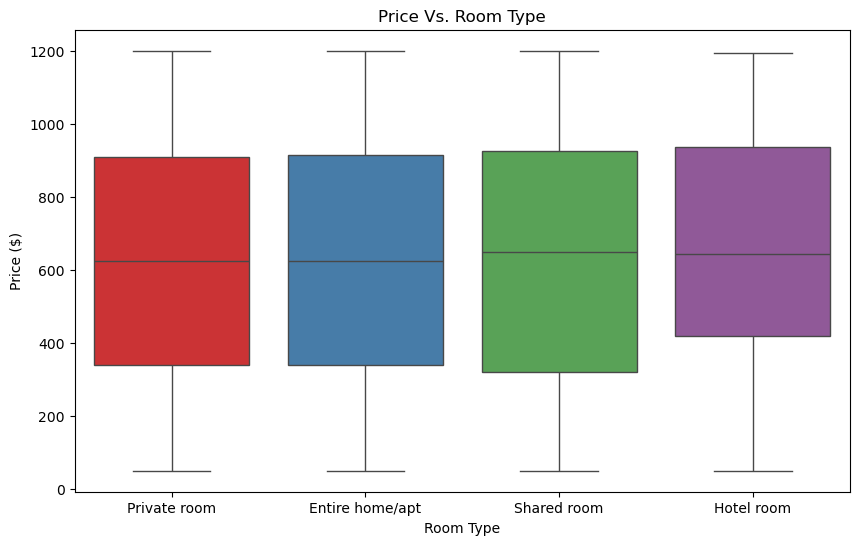

In [20]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'room type', y = 'price', data = df, hue = 'room type', palette = 'Set1')
plt.title('Price Vs. Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.show()

### The boxplot provides a detailed view of how prices vary across different types in Airbnb dataset.

### 'Shared room' tends to have lower prices, while 'Private rooms','Entire home/apt and, 'Hotel Room' have higher and more varied price ranges.

## Price Vs. Neighbourhood Group

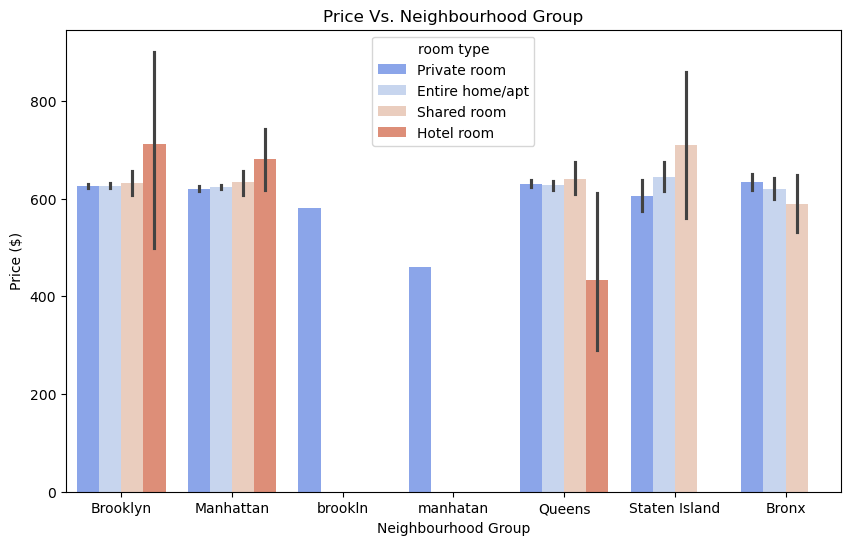

In [21]:
plt.figure(figsize = (10,6))
sns.barplot(x = 'neighbourhood group', y = 'price', data = df, hue = 'room type', palette = 'coolwarm')
plt.title('Price Vs. Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price ($)')
plt.show()

## Feature Selection

In [22]:
target = 'price'
X = df.drop(columns = [target])
y = df[target]

In [23]:
# Seperate numeric and categorical data

numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include = ['object', 'bool']).columns.tolist()

In [24]:
# Imputers

num_imputer = SimpleImputer(strategy = 'median')
X_num = num_imputer.fit_transform(X[numeric_features])
X_num_df = pd.DataFrame(X_num, columns = numeric_features)

cat_imputer = SimpleImputer(strategy = 'most_frequent')
X_cat = cat_imputer.fit_transform(X[categorical_features])

In [25]:
# Encode

encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
X_cat_encoded = encoder.fit_transform(X_cat)

In [26]:
X_cat_df = pd.DataFrame(X_cat_encoded, columns = encoder.get_feature_names_out(categorical_features))

In [27]:
# Combine using pandas

X_processed_df = pd.concat([X_num_df.reset_index(drop=True), X_cat_df.reset_index(drop=True)], axis=1)

## Splitting train and test sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size = 0.2, random_state = 42)

## k-NN model

In [29]:
# Fit into the model

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [30]:
# Prediction

y_pred_knn = knn.predict(X_test)

In [31]:
# Error calculation

mae = mean_absolute_error(y_test, y_pred_knn)
rmse = root_mean_squared_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 9.15
RMSE: 22.09
R² Score: 1.00


In [32]:
# baseline Score

baseline_score_knn = knn.score(X_test, y_test)
print(f'The baseline score is: {baseline_score_knn}')

The baseline score is: 0.995590113219101


In [33]:
# Reduce test size to avoid memory issues

# X_sub, y_sub = X_test[:1000], y_test[:1000]

In [34]:
# Permutation importance (reduced repeats)

#result = permutation_importance(knn, X_sub, y_sub, n_repeats=3, random_state=42, n_jobs=1)

In [35]:
# Put into DataFrame
'''perm_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for k-NN:")
print(perm_df.head(10))'''

'perm_df = pd.DataFrame({\n    \'Feature\': all_feature_names,\n    \'Importance\': results.importances_mean\n}).sort_values(by=\'Importance\', ascending=False)\n\nprint("Top 10 Important Features for k-NN:")\nprint(perm_df.head(10))'

## Random Forest Model

In [36]:
# Fit into the model

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
# Prediction

y_pred_rf = rf.predict(X_test)

In [38]:
# Error calculation

mae = mean_absolute_error(y_test, y_pred_rf)
rmse = root_mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 1.82
RMSE: 17.20
R² Score: 1.00


In [39]:
# Baseline Score

baseline_score_rf = rf.score(X_test, y_test)
print(f'The baseline score is: {baseline_score_rf}')

The baseline score is: 0.9973275369563622


In [40]:
# Reduce test size to avoid memory issues

X_sub, y_sub = X_test[:1000], y_test[:1000]

In [41]:
# Permutation importance 

result = permutation_importance(rf, X_sub, y_sub, n_repeats = 5, random_state = 42, n_jobs = 1)

In [50]:
# Put into DataFrame
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df.head(10))

                              Feature  Importance
3                         service fee    1.994983
97             neighbourhood_Flushing    0.000107
5                   number of reviews    0.000086
4                      minimum nights    0.000080
6                   reviews per month    0.000064
9                    availability 365    0.000040
227           neighbourhood_Wakefield    0.000027
0                                 lat    0.000021
1                                long    0.000020
32   neighbourhood_Bedford-Stuyvesant    0.000019


In [56]:
X_processed_df.to_csv("processed_airbnb_data.csv", index = False)

In [ ]:
y.to_csv("processed_airbnb_data_target.csv", index = fal)